In [1]:
pip install requests pandas matplotlib seaborn sqlalchemy


In [2]:
#  imports + primera prueba de la API (estructura y paginación)
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

url = "https://api.worldbank.org/v2/country"
params = {"format": "json", "per_page": 50, "page": 1}

response = requests.get(url, params=params, timeout=30)
response.raise_for_status()
payload = response.json()

print("Metadatos:", payload[0])      # paginación
print("Primer elemento:", payload[1][0])  # primer país de la página


Metadatos: {'page': 1, 'pages': 6, 'per_page': '50', 'total': 296}
Primer elemento: {'id': 'ABW', 'iso2Code': 'AW', 'name': 'Aruba', 'region': {'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Latin America & Caribbean '}, 'adminregion': {'id': '', 'iso2code': '', 'value': ''}, 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'}, 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'}, 'capitalCity': 'Oranjestad', 'longitude': '-70.0167', 'latitude': '12.5167'}


In [3]:
#  (config): países + indicadores + rango de años

BASE_URL = "https://api.worldbank.org/v2"

# 5 países en ISO3 (puedes cambiarlos si quieres)
countries = ["ESP", "USA", "CHN", "IND", "BRA"]

# Rango de años solicitado
START_YEAR = 2010
END_YEAR = 2024

# Indicadores (los recomendados en la guía)
indicators = {
    "population_total": "SP.POP.TOTL",
    "gdp_per_capita_usd": "NY.GDP.PCAP.CD",
    "co2_per_capita_tons": "EN.ATM.CO2E.PC",
    "life_expectancy_years": "SP.DYN.LE00.IN"
}

print("Países:", countries)
print("Años:", f"{START_YEAR}-{END_YEAR}")
print("Indicadores:", indicators)


Países: ['ESP', 'USA', 'CHN', 'IND', 'BRA']
Años: 2010-2024
Indicadores: {'population_total': 'SP.POP.TOTL', 'gdp_per_capita_usd': 'NY.GDP.PCAP.CD', 'co2_per_capita_tons': 'EN.ATM.CO2E.PC', 'life_expectancy_years': 'SP.DYN.LE00.IN'}


In [4]:
#  función para traer TODOS los resultados aunque la API esté paginada
# (World Bank devuelve payload[0]=metadatos y payload[1]=datos de esa página)

def wb_get_all_pages(url, params, timeout=30):
    all_items = []  # aquí iremos acumulando los datos de todas las páginas
    page = 1        # empezamos en la primera página

    while True:
        # Copio params para no modificar el original y le agrego la página actual
        params_page = dict(params)
        params_page["page"] = page

        # Hago el request
        r = requests.get(url, params=params_page, timeout=timeout)
        r.raise_for_status()
        payload = r.json()

        # Validación básica: si no viene en el formato esperado, corto
        # (a veces la API devuelve algo diferente si no hay datos)
        if not isinstance(payload, list) or len(payload) < 2 or payload[1] is None:
            break

        # Metadatos (paginación) y datos reales de esta página
        meta, data = payload[0], payload[1]

        # Agrego los datos de esta página a la lista final
        all_items.extend(data)

        # Si ya llegué a la última página, termino el while
        total_pages = int(meta.get("pages", 1) or 1)
        if page >= total_pages:
            break

        # Si no, paso a la siguiente página
        page += 1

    return all_items


In [5]:
#  Descargar datos (2010-2024) para varios países e indicadores
# Objetivo: guardar todo primero en una lista de diccionarios (records)

records = []

# Recorro cada indicador
for indicator_name, indicator_id in indicators.items():

    # La API permite pedir varios países separados por ;
    countries_str = ";".join(countries)

    # Endpoint para el indicador + países
    url = f"{BASE_URL}/country/{countries_str}/indicator/{indicator_id}"

    # Parámetros: formato JSON, rango de fechas, y per_page alto (igual puede haber paginación)
    params = {
        "format": "json",
        "per_page": 50,
        "date": f"{START_YEAR}:{END_YEAR}"
    }

    # Uso la función de paginación que hicimos en la celda 3
    items = wb_get_all_pages(url, params)

    # Guardo lo necesario en records (lista de diccionarios)
    for it in items:
        records.append({
            "indicator": indicator_name,
            "indicator_id": indicator_id,
            "country": it.get("country", {}).get("value"),
            "country_iso3": it.get("countryiso3code"),
            "year": it.get("date"),
            "value": it.get("value")
        })

# Convierto a DataFrame para ver si vino bien
raw_df = pd.DataFrame(records)

print("Filas descargadas:", raw_df.shape[0])
raw_df.head()


Filas descargadas: 225


,indicator,indicator_id,country,country_iso3,year,value
0,population_total,SP.POP.TOTL,Brazil,BRA,2024,211998573.0
1,population_total,SP.POP.TOTL,Brazil,BRA,2023,211140729.0
2,population_total,SP.POP.TOTL,Brazil,BRA,2022,210306415.0
3,population_total,SP.POP.TOTL,Brazil,BRA,2021,209550294.0
4,population_total,SP.POP.TOTL,Brazil,BRA,2020,208660842.0


In [6]:
# PASO 4: Transformar respuesta a DataFrames (1 por indicador) + limpieza mínima

dfs = {}  # aquí guardaré: dfs["gdp_per_capita_usd"] = DataFrame, etc.

for indicator_name in indicators.keys():
    # filtro solo las filas de ese indicador
    df_i = raw_df[raw_df["indicator"] == indicator_name][["country", "country_iso3", "year", "value"]].copy()

    # --- limpieza mínima (según instrucciones) ---
    # year a entero (primero a numérico por si viene como texto)
    df_i["year"] = pd.to_numeric(df_i["year"], errors="coerce").astype("Int64")

    # value a numérico (para poder graficar)
    df_i["value"] = pd.to_numeric(df_i["value"], errors="coerce")

    # eliminar filas con value nulo (cuando sea necesario -> aquí lo hacemos para trabajar limpio)
    df_i = df_i.dropna(subset=["value", "year"])

    # year a int normal
    df_i["year"] = df_i["year"].astype(int)

    # ordeno y reinicio índice
    df_i = df_i.sort_values(["country_iso3", "year"]).reset_index(drop=True)

    # guardo el DF de este indicador
    dfs[indicator_name] = df_i

# revisión rápida: tamaño de cada tabla
{k: v.shape for k, v in dfs.items()}


{'population_total': (75, 4),
 'gdp_per_capita_usd': (75, 4),
 'co2_per_capita_tons': (0, 4),
 'life_expectancy_years': (70, 4)}

In [7]:
# Asegurar que tenemos al menos 1 indicador ambiental con datos
# Intento usar CO2; si está vacío, uso renovables (% consumo final)

def download_indicator_simple(indicator_key, indicator_id):
    """Descarga un indicador (2010-2024) para los países y lo devuelve como DF limpio."""
    countries_str = ";".join(countries)
    url = f"{BASE_URL}/country/{countries_str}/indicator/{indicator_id}"
    params = {"format": "json", "per_page": 50, "date": f"{START_YEAR}:{END_YEAR}"}

    items = wb_get_all_pages(url, params)

    rows = []
    for it in items:
        rows.append({
            "country": it.get("country", {}).get("value"),
            "country_iso3": it.get("countryiso3code"),
            "year": it.get("date"),
            "value": it.get("value")
        })

    df = pd.DataFrame(rows)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["year", "value"])
    df["year"] = df["year"].astype(int)
    return df.sort_values(["country_iso3", "year"]).reset_index(drop=True)

# 1) Primero intento CO2 (el recomendado)
env_key_used = "co2_per_capita_tons"

if dfs.get(env_key_used, pd.DataFrame()).shape[0] == 0:
    # 2) Si CO2 está vacío, uso renovables %
    env_key_used = "renewable_energy_pct"
    env_id = "EG.FEC.RNEW.ZS"
    dfs[env_key_used] = download_indicator_simple(env_key_used, env_id)

print("Indicador ambiental que usaremos:", env_key_used)
print("Filas del indicador ambiental:", dfs[env_key_used].shape[0])


Indicador ambiental que usaremos: renewable_energy_pct
Filas del indicador ambiental: 60


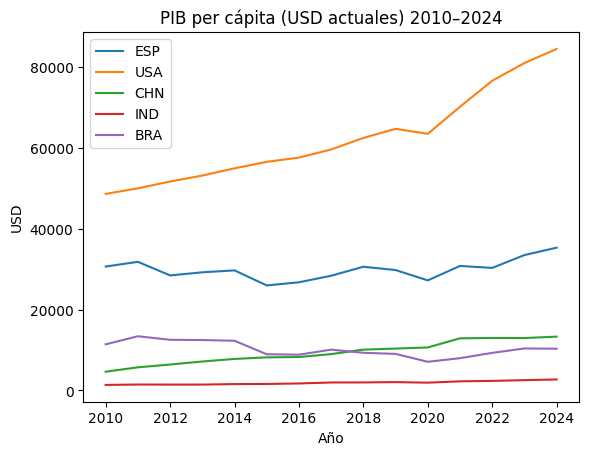

In [8]:
#  (Gráfico 1): Line chart - evolución del PIB per cápita por país (2010-2024)

df_gdp = dfs["gdp_per_capita_usd"]

plt.figure()

# dibujo una línea por cada país
for iso3 in countries:
    sub = df_gdp[df_gdp["country_iso3"] == iso3].sort_values("year")
    plt.plot(sub["year"], sub["value"], label=iso3)

plt.title("PIB per cápita (USD actuales) 2010–2024")
plt.xlabel("Año")
plt.ylabel("USD")
plt.legend()
plt.show()


Año del scatter: 2023


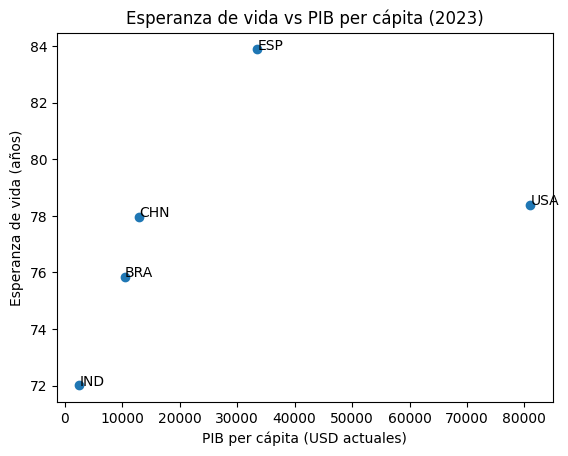

In [9]:
#  Scatter - relación entre PIB per cápita y esperanza de vida (año reciente común)

df_gdp = dfs["gdp_per_capita_usd"]
df_life = dfs["life_expectancy_years"]

# buscamos el último año que exista en ambos indicadores
years_gdp = set(df_gdp["year"].unique())
years_life = set(df_life["year"].unique())
common_years = sorted(list(years_gdp.intersection(years_life)))

year_scatter = common_years[-1]  # el más reciente
print("Año del scatter:", year_scatter)

# preparo tabla final: una fila por país con ambos valores en el mismo año
df_gdp_y = df_gdp[df_gdp["year"] == year_scatter][["country_iso3", "country", "value"]].rename(columns={"value": "gdp_pc"})
df_life_y = df_life[df_life["year"] == year_scatter][["country_iso3", "country", "value"]].rename(columns={"value": "life_exp"})

df_scatter = pd.merge(df_gdp_y, df_life_y, on=["country_iso3", "country"], how="inner")

# grafico
plt.figure()
plt.scatter(df_scatter["gdp_pc"], df_scatter["life_exp"])

# etiqueta por país
for _, row in df_scatter.iterrows():
    plt.annotate(row["country_iso3"], (row["gdp_pc"], row["life_exp"]))

plt.title(f"Esperanza de vida vs PIB per cápita ({year_scatter})")
plt.xlabel("PIB per cápita (USD actuales)")
plt.ylabel("Esperanza de vida (años)")
plt.show()


In [10]:
# Guardar los DataFrames en SQLite (una tabla por indicador)

# 1) creo el engine (crea el archivo si no existe)
engine = create_engine("sqlite:///world_bank_analysis.db", echo=False)

# 2) guardo cada DataFrame en una tabla
for indicator_name, df in dfs.items():
    table_name = f"indicator_{indicator_name}"
    df.to_sql(table_name, con=engine, if_exists="replace", index=False)

print("Tablas guardadas:", [f"indicator_{name}" for name in dfs.keys()])


Tablas guardadas: ['indicator_population_total', 'indicator_gdp_per_capita_usd', 'indicator_co2_per_capita_tons', 'indicator_life_expectancy_years', 'indicator_renewable_energy_pct']


In [11]:
# leo una muestra para comprobar que se guardó bien
sample = pd.read_sql("SELECT * FROM indicator_gdp_per_capita_usd LIMIT 10", con=engine)
sample


,country,country_iso3,year,value
0,Brazil,BRA,2010,11403.284004
1,Brazil,BRA,2011,13396.626316
2,Brazil,BRA,2012,12521.723845
3,Brazil,BRA,2013,12458.890340
4,Brazil,BRA,2014,12274.994163
5,Brazil,BRA,2015,8936.195589
6,Brazil,BRA,2016,8836.285460
7,Brazil,BRA,2017,10080.507872
8,Brazil,BRA,2018,9300.660729
9,Brazil,BRA,2019,9029.833044
